# LDA1

# Set Up

## Configs

In [21]:
n_terms = 4000
n_topics = 30
max_iter = 5
OHCO = ['book_id', 'chap_num', 'para_num']


In [22]:
import os
os.chdir('C:\\Users\\dwagn\\Downloads\\Project\\Project')

## Imports

In [23]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [24]:
%matplotlib inline

# Prepare Data

## Convert TOKENS to table of paragraphs

Scikit Learn wants an F1 style corpus. We create onefrom our annotated TOKEN table, keeping only regular nouns.

In [25]:
TOKENS = pd.read_csv('TOKEN2.csv')
PARAS = TOKENS[TOKENS.pos.str.match(r'^NNS?$')]\
    .groupby(OHCO).term_str\
    .apply(lambda x: ' '.join(x))\
    .to_frame()\
    .rename(columns={'term_str':'para_str'})

In [26]:
BOOKS = TOKENS[TOKENS.pos.str.match(r'^NNS?$')]\
    .groupby(OHCO[:1]).term_str\
    .apply(lambda x: ' '.join(x))\
    .to_frame()\
    .rename(columns={'term_str':'book_str'})

In [27]:
PARAS.head()

para_str
book_id chap_num para_num                                                   
121     31       0                                                      note
                 1                                             advertisement
                 2         work year publication bookseller business fart...
        32       1         one infancy born heroine situation character f...
                 2         ten appearances hair balls complexion improved...

In [28]:
BOOKS.head()

,book_str
book_id,
121,note advertisement work year publication books...
141,years thousand pounds luck county rank baronet...
42671,truth man possession fortune want wife feeling...


## Create Vector Space

In [29]:
tfv = CountVectorizer(max_features=n_terms, stop_words='english')
tf = tfv.fit_transform(PARAS.para_str)
TERMS = tfv.get_feature_names()

# Generate Model


In [30]:
lda = LDA(n_components=n_topics, max_iter=max_iter, learning_offset=50., random_state=0)

## THETA

In [31]:
THETA = pd.DataFrame(lda.fit_transform(tf), index=PARAS.index)
THETA.columns.name = 'topic_id'

In [32]:
THETA.sample(20).style.background_gradient()

## PHI

In [33]:
PHI = pd.DataFrame(lda.components_, columns=TERMS)
PHI.index.name = 'topic_id'
PHI.columns.name  = 'term_str'

In [34]:
PHI.T.head().style.background_gradient()

topic_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
term_str,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
abatement,0.033333,0.033333,0.033333,1.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,1.033333,0.033333,0.033333,0.033333,0.033333,0.033333,1.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
abbey,2.254763,0.033333,0.033333,0.033333,2.368230,3.007307,0.033333,0.033333,0.033333,0.033333,2.215456,1.033333,0.033333,0.033333,3.067315,2.478092,0.614601,0.033333,0.033333,3.250129,1.698437,1.168513,0.033333,3.418664,1.033333,0.984504,0.033333,1.907323,0.033333,0.033333
abbeys,2.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
abhorrence,0.033333,0.033333,0.033333,0.033333,1.480584,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,1.033333,0.033333,0.033333,1.033333,1.033333,0.033333,0.033333,0.033333,0.033333,0.033333,1.033333,0.033333,0.033333,0.033333,1.033333,0.033333,0.033333,0.033333,0.586083
abilities,1.033333,0.033333,3.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,1.033333,0.033333,1.033333,0.033333,1.033333,0.033333,0.033333,0.033333,1.033333,0.033333,0.033333,0.033333,0.033333,0.033333,1.033333,3.033333,0.033333,1.033333,1.033333


# Inspect Results

## Get Top Terms per Topic

In [35]:
TOPICS = PHI.stack().to_frame().rename(columns={0:'weight'})\
    .groupby('topic_id')\
    .apply(lambda x: 
           x.weight.sort_values(ascending=False)\
               .head(10)\
               .reset_index()\
               .drop('topic_id',1)\
               .term_str)

In [36]:
TOPICS

term_str,0,1,2,3,4,5,6,7,8,9
topic_id,,,,,,,,,,
0,opinion,feelings,time,nature,subject,pleasure,state,mind,heart,cousins
1,time,day,party,pleasure,house,question,family,hour,dinner,morning
2,family,country,character,mind,world,idea,fortune,house,marriage,sister
3,man,choice,comfort,husband,thing,time,daughter,father,gentleman,life
4,man,time,family,sister,feelings,happiness,home,opinion,day,life
5,acquaintance,friends,friend,home,family,pause,wish,kind,opinion,years
6,room,time,countenance,moment,man,mother,letter,day,beauty,way
7,distance,things,room,people,night,thing,miles,world,time,kind
8,time,home,rest,sister,heart,truth,necklace,room,people,sorry


In [37]:
TOPICS['label'] = TOPICS.apply(lambda x: str(x.name) + ' ' + ' '.join(x[:7].astype('str')), 1)

In [38]:
TOPICS.label

topic_id
0     0 opinion feelings time nature subject pleasur...
1       1 time day party pleasure house question family
2     2 family country character mind world idea for...
3      3 man choice comfort husband thing time daughter
4      4 man time family sister feelings happiness home
5     5 acquaintance friends friend home family paus...
6      6 room time countenance moment man mother letter
7       7 distance things room people night thing miles
8          8 time home rest sister heart truth necklace
9           9 place time family sisters plan year house
10       10 time friend days pleasure spirits visit day
11            11 oh time house moment room theatre door
12              12 yes thing sister good time months oh
13           13 look man woman ladies word character oh
14      14 madam table morning house servants said time
15      15 answer time day pleasure feelings way mother
16             16 sir sisters care oh sister town power
17             17 love girl sort moment

## Sort Topics by Doc Weight

In [39]:
TOPICS['doc_weight_sum'] = THETA.sum()

<AxesSubplot:ylabel='label'>

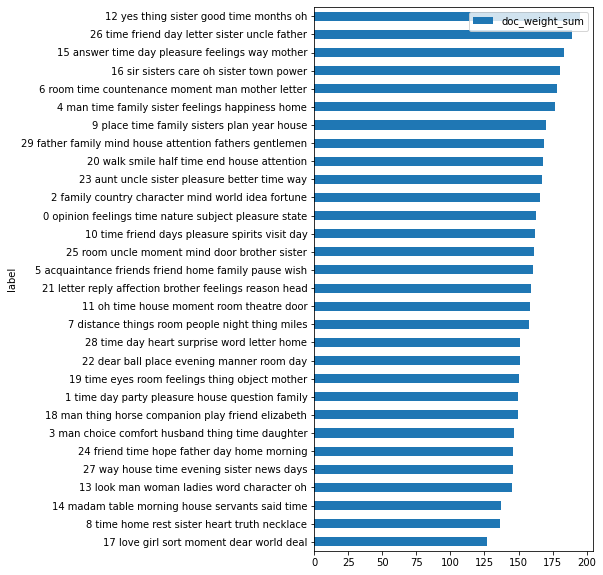

In [40]:
TOPICS.sort_values('doc_weight_sum', ascending=True).plot.barh(y='doc_weight_sum', x='label', figsize=(5,10)) 

## Explore Topics by Author

In [41]:
LIB = pd.read_csv('LIB.csv').set_index('book_id')

In [42]:
topic_cols = [t for t in range(n_topics)]

In [43]:
AUTHORS = THETA.join(LIB, on='book_id')\
    .reset_index().set_index(['author']+OHCO)\
    .groupby('author')[topic_cols].mean()\
    .T                                            
AUTHORS.index.name = 'topic_id'

In [44]:
AUTHORS['topterms'] = TOPICS[[i for i in range(10)]].apply(lambda x: ' '.join(x), 1)

In [45]:
AUTHORS.sort_values('austen', ascending=False).style.background_gradient()

author,austen,topterms
topic_id,,
12,0.040655,yes thing sister good time months oh moments pleasure away
26,0.039403,time friend day letter sister uncle father brother morning character
15,0.038274,answer time day pleasure feelings way mother oh mind word
16,0.037521,sir sisters care oh sister town power men wonder cousin
6,0.037054,room time countenance moment man mother letter day beauty way
4,0.036783,man time family sister feelings happiness home opinion day life
9,0.035383,place time family sisters plan year house wife people ladies
29,0.035138,father family mind house attention fathers gentlemen mother time subject
20,0.035010,walk smile half time end house attention place behaviour eyes


In [46]:
AUTHORS.sort_values('austen', ascending=False).style.background_gradient()

author,austen,topterms
topic_id,,
12,0.040655,yes thing sister good time months oh moments pleasure away
26,0.039403,time friend day letter sister uncle father brother morning character
15,0.038274,answer time day pleasure feelings way mother oh mind word
16,0.037521,sir sisters care oh sister town power men wonder cousin
6,0.037054,room time countenance moment man mother letter day beauty way
4,0.036783,man time family sister feelings happiness home opinion day life
9,0.035383,place time family sisters plan year house wife people ladies
29,0.035138,father family mind house attention fathers gentlemen mother time subject
20,0.035010,walk smile half time end house attention place behaviour eyes


In [47]:
import plotly_express as px

In [50]:
px.scatter(AUTHORS.reset_index(), 'austen', hover_name='topterms', text='topic_id')\
    .update_traces(mode='text')

# Clutser Topics

In [51]:
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

In [52]:
def plot_tree(tree, labels):
    plt.figure()
    fig, axes = plt.subplots(figsize=(5, 10))
    dendrogram = sch.dendrogram(tree, labels=labels, orientation="left")
    plt.tick_params(axis='both', which='major', labelsize=14)

In [53]:
SIMS = pdist(normalize(PHI), metric='euclidean')
TREE = sch.linkage(SIMS, method='ward')

In [54]:
labels  = ["{}: {}".format(a,b) for a, b in zip(AUTHORS.index,  AUTHORS.topterms.tolist())]

<Figure size 432x288 with 0 Axes>

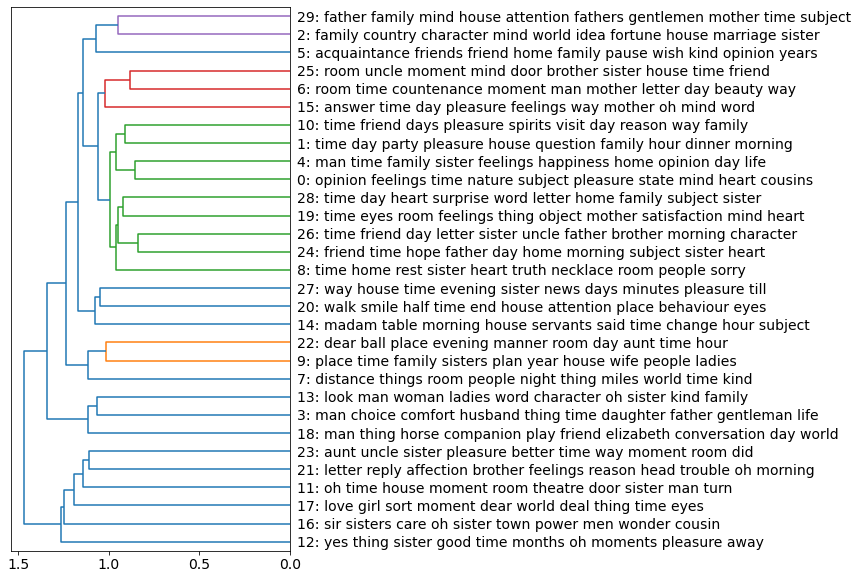

In [55]:
plot_tree(TREE, labels)